In [1]:
from qampy import signals,impairments,helpers,equalisation,io,filtering
from qampy.core import impairments as impair

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [3]:
def plot_spec(sig):
    mysig = atleast_2d(sig)
    figure(figsize=(4,4))
    faxis=fftfreq(mysig.shape[1],1/2)
    psd = 20*log10(abs(fft.fft(mysig[0])))
    plot(faxis,psd-psd.max())
    xlabel("Normalized Frequency")
    ylabel("Relative Power")
    title("Channel after pulse-shaping")

def plot_1d(mysig,figsize):
    figure(figsize=figsize)
    plot(mysig.real.flatten(),mysig.imag.flatten(),'b.')
    axis("square")
    # xticks([])
    # yticks([])
    # axis([-1.5,1.5,-1.5,1.5])
    title("Complete Frame")
    show()

In [4]:
M = 16
N = 2**16 
nmodes = 1
fb = 20e9
sig = signals.SignalQAMGrayCoded(M,N,nmodes=nmodes,fb=fb)
sigResam = sig.resample(2*sig.fb,beta=0.2)

In [5]:
print('%f %f'%(abs(sigResam.real).max(),abs(sigResam.imag).max()))

1.669967 1.674234


In [6]:
powsig_mean = (np.abs(sigResam.real)**2).mean() # mean power at real or imag part
x_max = maximum( abs(sigResam.real).max(),abs(sigResam.imag).max())  # maximum amplitude at real or imag part
ENOB = 6
delta = x_max/(2**(ENOB-1))
pownoise_mean = delta**2/12    # notice: this is the noise power for only real or imag part.(2-time for whole signal)
# add noise to complex signal with 2-time pownoise_mean because  
sig_ENOB_noise = impairments.add_awgn(sigResam,sqrt(2*pownoise_mean))

In [7]:
pownoise_mean*2

SignalQAMGrayCoded(0.00045623)

Test DAC function

In [8]:
[filter_sig, sigq, snr_enob] = impairments.sim_DAC_response(sigResam, 6, 5e9, quantizer_model=True)

In [9]:
(abs(sigq-sigResam)**2).mean()

SignalQAMGrayCoded(0.00045693)

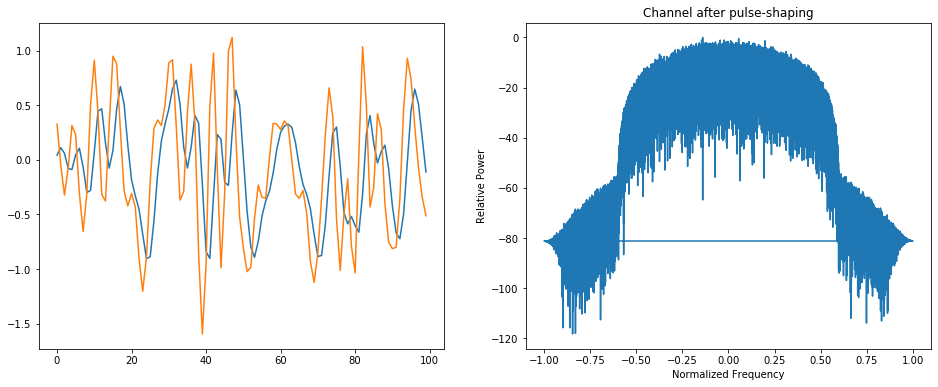

In [10]:
figure(figsize=(16,6))
subplot(121)
plot(filter_sig.real[0,:100])
plot(sigResam.real[0,0:100])
subplot(122)
mysig = atleast_2d(filter_sig)
faxis=fftfreq(mysig.shape[1],1/2)
psd = 20*log10(abs(fft.fft(mysig[0])))
plot(faxis,psd-psd.max())
xlabel("Normalized Frequency")
ylabel("Relative Power")
title("Channel after pulse-shaping")
show()

Test Modulator

In [4]:
M = 16
N = 2**16 
nmodes = 1
fb = 20e9
sig = signals.SignalQAMGrayCoded(M,N,nmodes=nmodes,fb=fb)
sigResam = sig.resample(2*sig.fb,beta=0.1)

target_voltage = 5.5    # Vpi=3.5 v
sig_amp = impair.ideal_amplifier_response(sigResam,target_voltage)
sig_mod_out = impair.modulator_response(sig_amp, sig_amp.fs)

sig_mod_out_N = impairments.change_snr(sig_mod_out,20) 

rxsig = sig_mod_out_N.resample(sig.fb,beta=0.1,renormalise=True)
rxsig = helpers.normalise_and_center(rxsig)

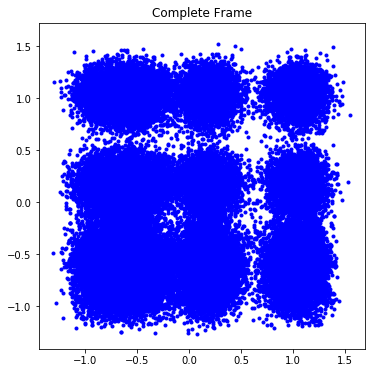

In [5]:
plot_1d(rxsig,(6,6))